# MeshKernel refinement

This is the basic introduction for refining a mesh using geographical coordinates.

At the very beginning, the necessary libraries have to be imported.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from meshkernel import (
    CurvilinearParameters,
    MakeGridParameters,
    MeshRefinementParameters,
    RefinementType,
    GeometryList,
    MeshKernel
)
import numpy as np
import contextily as ctx

plt.close('all')


Generate a mesh

In [2]:
# general settings
lon_min,lon_max = -6,2
lat_min,lat_max = 48.5,51.2
lon_res,lat_res = 0.2,0.2
num_x = int(np.ceil((lon_max-lon_min)/lon_res))
num_y = int(np.ceil((lat_max-lat_min)/lat_res))


"""
Make a regular (potentially rotated) rectilinear grid. First generate a curvilinear grid than convert the curvilinear grid into unstructured grid. The steps are the following:
- curvilinear_make_uniform, see the following notebook: https://github.com/Deltares/MeshKernelPy/blob/AddCurvilinearGridSupport/docs/examples/04_curvilineargrid_basics.ipynb
- curvilinear_convert_to_mesh2d: https://github.com/Deltares/MeshKernelPy/blob/118cb4953c4e95d5b18ed283bb37f391134b2bb2/meshkernel/meshkernel.py#L1399 

"""

# Create an instance of MakeGridParameters and set the values
make_grid_parameters = MakeGridParameters()
make_grid_parameters.num_columns = num_x
make_grid_parameters.num_rows = num_y
make_grid_parameters.angle = 0.0
#make_grid_parameters.block_size = 0.0
make_grid_parameters.origin_x = lon_min
make_grid_parameters.origin_y = lat_min
make_grid_parameters.block_size_x = lon_res
make_grid_parameters.block_size_y = lat_res

pol_x = np.empty(0, dtype=np.double)
pol_y = np.empty(0, dtype=np.double)
geometry_list = GeometryList(pol_x, pol_y)

mk1 = MeshKernel()
mk1.curvilinear_make_uniform(make_grid_parameters, geometry_list) 
mk1.curvilinear_convert_to_mesh2d() #convert to ugrid/mesh2d
mesh2d_grid1 = mk1.mesh2d_get() #in case of curvi grid: mk.curvilinear_convert_to_mesh2d()

Refine a mesh based on bathymetry (GEBCO_2021_cutout.nc)

In [3]:
"""
Mesh refinement in MeshKernelPy with bathymetry samples and plot result
"""
#select and plot bathy
file_nc_bathy = r'.\data_examples\refinement\GEBCO_2021_cutout.nc'
data_bathy = xr.open_dataset(file_nc_bathy)
data_bathy_sel = data_bathy.sel(lon=slice(lon_min-1,lon_max+1),lat=slice(lat_min-1,lat_max+1))

#convert bathy data to geomlist
samp_x,samp_y = np.meshgrid(data_bathy_sel.lon.values,data_bathy_sel.lat.values)
samp_z = data_bathy_sel.elevation.values.astype(float) 
samp_x = samp_x.ravel()
samp_y = samp_y.ravel()
samp_z = samp_z.ravel()
geomlist = GeometryList(x_coordinates=samp_x, y_coordinates=samp_y, values=samp_z)

#refinement
mesh_refinement_parameters = MeshRefinementParameters(refine_intersected=False,
                                                      use_mass_center_when_refining=False, 
                                                      min_face_size=0.01, 
                                                      refinement_type=RefinementType(1), #Wavecourant/1,
                                                      connect_hanging_nodes=True, #set to False to do multiple refinement steps (e.g. for multiple regions)
                                                      account_for_samples_outside_face=False, #outsidecell argument for --refine?
                                                      max_refinement_iterations=5)

Define a function for creating an uniform curvilinear grid

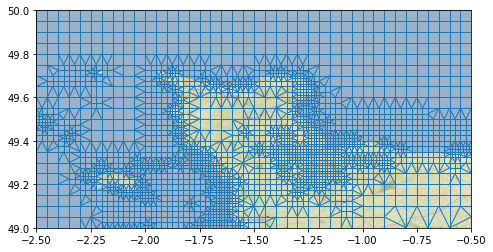

In [4]:
mk2 = MeshKernel()
mk2.curvilinear_make_uniform(make_grid_parameters, geometry_list)
mk2.curvilinear_convert_to_mesh2d()
mk2.mesh2d_refine_based_on_samples(samples=geomlist,
                                   relative_search_radius=0.5, 
                                   minimum_num_samples=3,
                                   mesh_refinement_params=mesh_refinement_parameters,
                                   )

mesh2d_grid2 = mk2.mesh2d_get()

#zoomed in plot to focus on patchy coastlines

figsize = (10,4)
crs = 'EPSG:4326'

fig, ax = plt.subplots(figsize=figsize)
mesh2d_grid2.plot_edges(ax,linewidth=1)
ax.set_xlim(-2.5,-0.5)
ax.set_ylim(49,50)
ctx.add_basemap(ax=ax, crs=crs, attribution=False)